[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aurelio-labs/cookbook/blob/main/gen-ai/openai/gpt4/gpt-4-functions.ipynb)

# Function Calling in GPT4

On the 13th June 2023 OpenAI released two new models, `gpt-3.5-turbo-0613` and `gpt-4-0613`. Both models bring a new feature called **function calling** to the API.

Function calling allows us to describe code functions to the model, and the model will identify our intention and return a JSON object containing the arguments needed to call the function.

Let's start by installing prerequisite libraries.

In [1]:
!pip install -qU \
  "openai==0.27.8" \
  "diffusers==0.17.1" \
  "transformers==4.30.2" \
  "accelerate==0.20.3" \
  "scipy==1.10.1" \
  "safetensors==0.3.1" \
  "xformers==0.0.20"

We import `openai` and authenticate with a [free API key](https://platform.openai.com).

In [2]:
import openai

openai.api_key = "sk-..."

# confirm authentication was successful
openai.Engine.list()['data'][0]

<Engine engine id=whisper-1 at 0x7fb1d6f0c450> JSON: {
  "object": "engine",
  "id": "whisper-1",
  "ready": true,
  "owner": "openai-internal",
  "permissions": null,
  "created": null
}

Looks good, now let's create a function that we will be using GPT-4 to call.

In [3]:
from IPython.display import HTML

def page_builder(title: str, copy_text: str):
    """Takes title and copy text to create a product page in simple HTML
    """
    html = """<!DOCTYPE html>
<html>
    <head>
        <title>Awesome Product</title>
        <style>
            body {
                background-color: #f0f0f0;
                font-family: Arial, sans-serif;
            }
            .container {
                width: 80%;
                margin: auto;
                padding: 20px;
                background-color: #ffffff;
                box-shadow: 0px 0px 10px #bbbbbb;
                text-align: center;
            }
            h1 {
                color: #333333;
                margin-bottom: 20px;
            }
            p {
                color: #666666;
                font-size: 16px;
                line-height: 1.5;
            }
        </style>
    </head>
    <body>
        <div class="container">
            <h1>"""+title+"""</h1>
            <p>"""+copy_text+"""</p>
        </div>
    </body>
</html>"""
    with open('index.html', 'w') as fp:
        fp.write(html)
    return HTML(filename='index.html')

We can use the function like so:

In [4]:
page_builder(
    title="Awesome Product",
    copy_text="Not very good copy text (it was written by a human)."
)

Now let's ask GPT-4 to create the input to our function. We translate the function above into a function GPT-4 understands with:

In [5]:
page_builder_func = {
    "name": "page_builder",
    "description": "Creates product web pages",
    "parameters": {
        "type": "object",
        "properties": {
            "title": {
                "type": "string",
                "description": "The name of the product"
            },
            "copy_text": {
                "type": "string",
                "description": "Marketing copy that describes and sells the product"
            }
        },
        "required": ["title", "copy_text"]
    }
}

Now we call the model using the typical format, but this time we add a new `functions` parameter that includes our `func_str`.

In [6]:
prompt = "Create a web page for a new cutting edge mango cutting machine"

res = openai.ChatCompletion.create(
    model='gpt-4-0613',  # swap for gpt-3.5-turbo-0613 if needed
    messages=[{"role": "user", "content": prompt}],
    functions=[page_builder_func]
)
res

<OpenAIObject chat.completion id=chatcmpl-7RGH11ZRqATI0shE6nLTqgslsCwfT at 0x7fb1f3ec5080> JSON: {
  "id": "chatcmpl-7RGH11ZRqATI0shE6nLTqgslsCwfT",
  "object": "chat.completion",
  "created": 1686731767,
  "model": "gpt-4-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": null,
        "function_call": {
          "name": "page_builder",
          "arguments": "{\n\"title\": \"Cutting Edge Mango Cutting Machine\",\n\"copy_text\": \"Welcome to the launch of our latest innovation, the Cutting Edge Mango Cutting Machine! This device guarantees ease and precision when slicing your favorite tropical fruit. No more worrying about wasting parts of the mango or struggling with the pit - our machine ensures every cut is perfect. Safety is also a top priority - its unique design keeps your fingers safely away from the blade. The Cutting Edge Mango Cutting Machine isn\u2019t just a gadget, it\u2019s a game-changer in your kitchen!\"\n

Now we can check to see if GPT-4 decided we should call a function:

In [7]:
if res['choices'][0]["finish_reason"] == "function_call":
    print("We should call a function!")

We should call a function!


Okay, looks like we should call a function, now we can check the name of the function to be called and what parameters to pass to it:

In [8]:
import json

name = res['choices'][0]['message']['function_call']['name']
args = json.loads(res['choices'][0]['message']['function_call']['arguments'])
name, args

('page_builder',
 {'title': 'Cutting Edge Mango Cutting Machine',
  'copy_text': 'Welcome to the launch of our latest innovation, the Cutting Edge Mango Cutting Machine! This device guarantees ease and precision when slicing your favorite tropical fruit. No more worrying about wasting parts of the mango or struggling with the pit - our machine ensures every cut is perfect. Safety is also a top priority - its unique design keeps your fingers safely away from the blade. The Cutting Edge Mango Cutting Machine isn’t just a gadget, it’s a game-changer in your kitchen!'})

And run the function:

In [9]:
page_builder(**args)

Nice, but we're missing something — maybe a interesting AI generated product image would be a good addition. For that we need a image generation model. Fortunately, we can initialize one easily using Hugging Face *Diffusers* like so:

cuda


  0%|          | 0/50 [00:00<?, ?it/s]

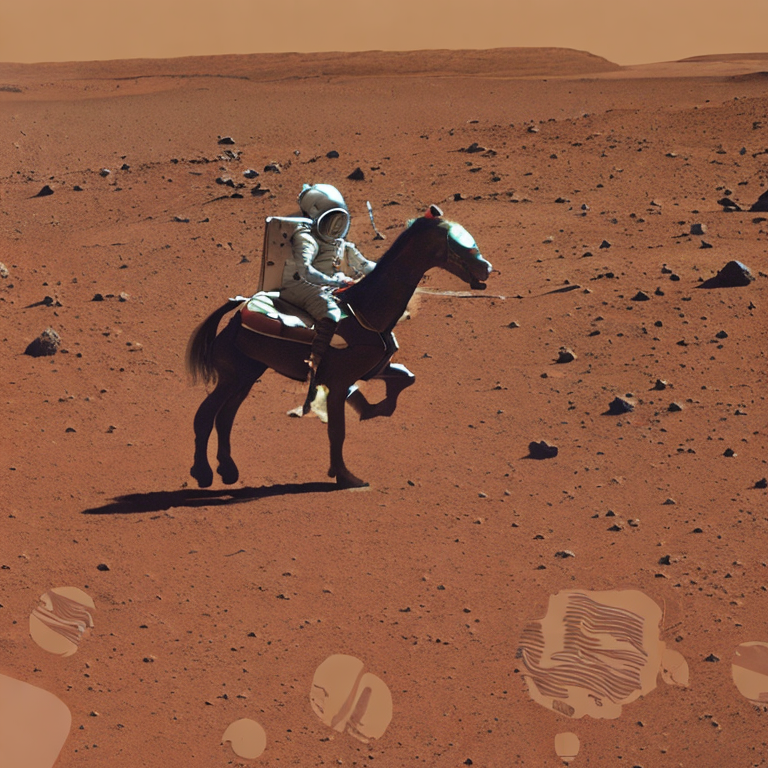

In [10]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

# use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model_id = "stabilityai/stable-diffusion-2-1"

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)

test_prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(test_prompt).images[0]

image.show()

Okay so we can generate images, now all we need to do is connect that functionality to our `page_builder` function, and update our function description so that GPT-4 knows how to use the image generation feature.

In [46]:
def page_builder(title: str, copy_text: str, image_desc: str):
    """Takes title and copy text to create a product page in simple HTML
    """
    # generate the image and save
    image = pipe(image_desc).images[0]
    image.save("product.jpg")
    # generate html
    html = """<!DOCTYPE html>
<html>
    <head>
        <title>Awesome Product</title>
        <style>
            body {
                background-color: #f0f0f0;
                font-family: Arial, sans-serif;
            }
            .container {
                width: 80%;
                margin: auto;
                padding: 20px;
                background-color: #ffffff;
                box-shadow: 0px 0px 10px #bbbbbb;
                margin-top: 100px;
                text-align: center;
            }
            h1 {
                color: #333333;
                margin-bottom: 20px;
            }
            p {
                color: #666666;
                font-size: 16px;
                line-height: 1.5;
            }
            img {
                max-width: 50%;
                height: auto;
                margin-bottom: 20px;
            }
        </style>
    </head>
    <body>
        <div class="container">
            <img src="product.jpg">
            <h1>"""+title+"""</h1>
            <p>"""+copy_text+"""</p>
        </div>
    </body>
</html>"""
    # prepare html file and display
    with open('index.html', 'w') as fp:
        fp.write(html)

We need to add the new parameter to the `"properties"` of the `page_builder_func`.

In [47]:
page_builder_func = {
    "name": "page_builder",
    "description": "Creates product web pages",
    "parameters": {
        "type": "object",
        "properties": {
            "title": {
                "type": "string",
                "description": "The name of the product"
            },
            "copy_text": {
                "type": "string",
                "description": "Marketing copy that describes and sells the product"
            },
            "image_desc": {
                "type": "string",
                "description": "Concise description of the product image using descriptive language, no more than two sentences long"
            }
        },
        "required": ["title", "copy_text", "image_desc"]
    }
}

Now let's run this again, we'll wrap the logic up into a single function.

In [48]:
def query(prompt: str):
    res = openai.ChatCompletion.create(
        model='gpt-4-0613',  # swap for gpt-3.5-turbo-0613 if needed
        messages=[{"role": "user", "content": prompt}],
        functions=[page_builder_func]
    )
    if res['choices'][0]["finish_reason"] == "function_call":
        # this means we should call a function
        name = res['choices'][0]['message']['function_call']['name']
        args = json.loads(res['choices'][0]['message']['function_call']['arguments'])
        if name == 'page_builder':
            page_builder(**args)
        else:
            raise ValueError(f"Function name `{name}` not recognized!")
        return HTML('index.html')

In [49]:
query(prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

---

_🚨 If you are running this in a colab notebook you need to download the `product.png` and `index.html` files and open `index.html` locally to see the final page!_

---

With that we have our GPT-4-built product page!